In [41]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch

In [42]:
class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)

def t2np(t):
    return ((t.permute(1, 2, 0) + 1) / 2).clamp(0,1).cpu().numpy()

Initialize args

In [43]:
config_dict = {
    # TASK NAME
    'task_name': 'rxrx1_batch',

    # IMAGE
    'img_size': 96,
    'latent_dim': 100,
    'hidden_dim': 512,
    'style_dim': 64,
    'stochastic': True,
    'z_dimension': 10,
    'dim_in': 64,
    'pert_modelling': False,
    'batch_key': 'BATCH',
    'subsample_frac': 1.0,

    # LOSS
    'lambda_reg': 1,
    'lambda_cyc': 1,
    'lambda_sty': 1,
    'lambda_ds': 1,

    # TRAINING
    'total_epochs': 100,
    'ds_iter': 100000,
    'resume_iter': 0,
    'batch_size': 32,
    'val_batch_size': 20,
    'lr': 0.0001,
    'f_lr': 0.0001,
    'beta1': 0,
    'beta2': 0.99,
    'weight_decay': 0.0001,
    'num_outs_per_domain': 10,
    'single_style': True,
    'ood_set': None,
    'mol_list': None,
    'balanced': False,
    'trainable_emb': True,
    'dataset_name': 'rxrx1',
    'n_channels': 6,
    'num_workers': 6,
    'seed': 42,

    # DIRECTORIES FOR DATA
    'image_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1',
    'data_index_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv',
    'embedding_path': None,

    # DIRECTORIES FOR RESULTS
    'experiment_directory': '../project_folder/experiments/',
    'sample_dir': 'sample',
    'checkpoint_dir': 'checkpoint',
    'basal_vs_real_folder': 'basal_vs_real',
    'naming_key': 'dataset_name',
    'embedding_folder': 'embeddings',
    'resume_dir': '',

    # DATA HANDLEMENT
    'augment_train': True,
    'normalize': True,

    # LOGGING INFO
    'print_every': 10,
    'sample_every': 1000,
    'save_every': 500,
    'eval_every': 500,

    # PARAMETERS FOR CONDITION ENCODING
    'encode_rdkit': True,
    'num_layers_mapping_net': 1,

    # Lightning
    'filename': 'epoch_{epoch:04d}',
    'monitor': 'fid_transformations',
    'mode': 'min',
    'save_last': True,
    'offline': False,
    'project': 'rxrx1_batch',
    'log_model': False,
    'accelerator': 'gpu',
    'log_every_n_steps': 10
}

args = OmegaConf.create(config_dict)
dataloader = CellDataLoader(args)

In [44]:
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch"

Initialize solver 

In [45]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(53)
solver.to("cuda")

Number of parameters in generator: 24320518
Number of parameters in style_encoder: 14331200
Number of parameters in discriminator: 14299907
Number of parameters in mapping_network: 7104
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_nets.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_nets.ckpt
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch/checkpoint/000053_embeddings.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b77

IMPAmodule(
  (embedding_matrix): Embedding(3, 100)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (conv1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [46]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [47]:
target_folder = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1_transported")

In [48]:
# Transform all with the same random vector. Take the mean 
z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for loader in [train_dataloader, val_dataloader]:
        for batch in tqdm(loader):
            # # Get image 
            X = batch["X"].cuda()
            z = z_common.repeat(X.shape[0], 1)
            # Transport everything to a chosen batch, here we pick 0
            y = 0*torch.ones(X.shape[0]).long().cuda()
            y = solver.embedding_matrix(y).cuda()
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
            _, X_generated = solver.nets.generator(X, y)
            for i, filename in enumerate(batch["file_names"]):
                # Draw file name
                filenames_split = filename.split("-")[1].split("_")
                batch_key = '_'.join(filenames_split[:2])
                well_key = filenames_split[2]
                image_key = '_'.join(filenames_split[3:])
                # Process and save
                to_save = t2np(X_generated[i])
                to_save = (to_save*255).astype(np.uint8)
                path = target_folder/batch_key/well_key
                
                # Save images 
                os.makedirs(path,  exist_ok=True)
                np.save(path/f"{image_key}.npy", to_save)

100%|██████████| 1714/1714 [02:55<00:00,  9.75it/s]


Real


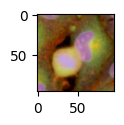

Transformed


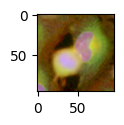

Real


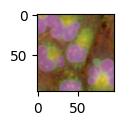

Transformed


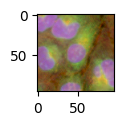

Real


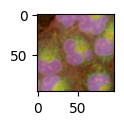

Transformed


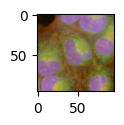

Real


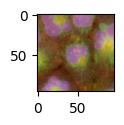

Transformed


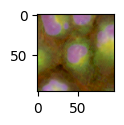

Real


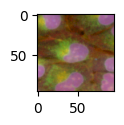

Transformed


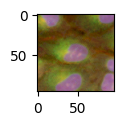

Real


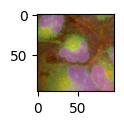

Transformed


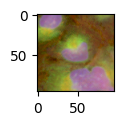

Real


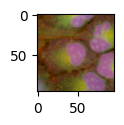

Transformed


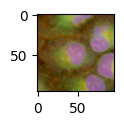

Real


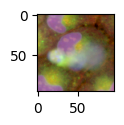

Transformed


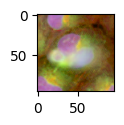

Real


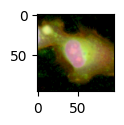

Transformed


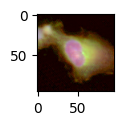

Real


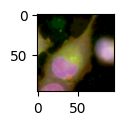

Transformed


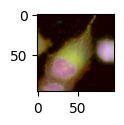

In [51]:
for i in range(len(X)):
    print("Real")
    plt.figure(figsize=(1,1))
    plt.imshow(t2np(X[i])[:,:,[5,1,0]])
    plt.show()
    print("Transformed")
    plt.figure(figsize=(1,1))
    plt.imshow(t2np(X_generated[i])[:,:,[5,1,0]])
    plt.show()